<a href="https://colab.research.google.com/github/shelleyg-bit/canada-land-cover-classifier/blob/main/download_sentinel_from_gee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=diYH2IV-Zsa2YMYQa2RMa0SMnrfzxpSTA3Nxpj7zslE&tc=-GmensgTk5g8avibAzAGnYe1_Oa-SPRbI1-NS_a0Gxc&cc=Tp9482bhO20fig_szYq8ZJzLIzcUXXjvH_5LqFZXd3Y

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiD0zIY4eIE53_2Cgx5Z4CcuObkiXlsFu1ap_fTAd5W6BvHS9wE3QE

Successfully saved authorization token.


In [ ]:
!pip install geopandas
!pip install rasterio

In [ ]:
import rasterio as rio
import geopandas as gpd
from matplotlib import pyplot as plt

# Prepare BBox

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 6125, 'height': 4496, 'count': 1, 'crs': CRS.from_epsg(3978), 'transform': Affine(30.0, 0.0, -1533684.509203629,
       0.0, -30.0, 576208.2823371678), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


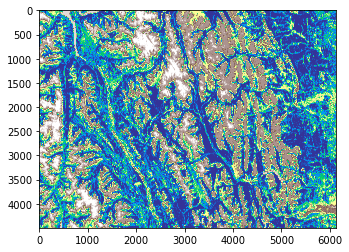

In [ ]:
lc_data_dir = '/content/drive/MyDrive/nrcan/lc_data'
with rio.open(f'{lc_data_dir}/aoi1_lc.tif', 'r') as src:
  lc = src.read(1)
  lc_profile = src.profile.copy()
  lc_bounds = src.bounds
  print(src.profile)
plt.imshow(lc, cmap='terrain')

In [ ]:
lc_bounds

BoundingBox(left=-1533684.509203629, bottom=441328.28233716777, right=-1349934.509203629, top=576208.2823371678)

In [ ]:
type(lc_bounds)

rasterio.coords.BoundingBox

In [ ]:
l, b, r, t = lc_bounds

In [ ]:
print(*lc_bounds)

-1533684.509203629 441328.28233716777 -1349934.509203629 576208.2823371678


In [ ]:
from shapely.geometry import Polygon
bbox = Polygon([(l,b), (l,t), (r,t), (r,b)])
aoi_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=lc_profile['crs'])

In [ ]:
aoi_gdf

,geometry
0,"POLYGON ((-1533684.509 441328.282, -1533684.50..."


# Get Sentinel Images

In [ ]:
!pip install geemap

In [215]:
# method to remove cloud from the image
def maskclouds(image: ee.Image) -> ee.Image:
    """To mask clouds using the Sentinel-2 QA band
    @param {ee.Image} image Sentinel-2 image
    @return {ee.Image} cloud masked Sentinel-2 image
    """
    band_qa = image.select('QA60')
    cloud_mask = ee.Number(2).pow(10).int()
    cirrus_mask = ee.Number(2).pow(11).int()
    mask = band_qa.bitwiseAnd(cloud_mask).eq(0) and(
        band_qa.bitwiseAnd(cirrus_mask).eq(0))
    return image.updateMask(mask).divide(10000)

def fndvi(image: ee.Image) -> ee.Image:
    """Add NDVI to each pixel in an image"""
    #TODO: ask toby about this NDVI calculation
    # since its 20m resolution
    # there are other NDVIs at 10m resolution
    ndvi = image.expression(
    "(NIR-RED)/(NIR+RED)",
    {
        'RED': image.select('B4').multiply(0.0001),
        'NIR' : image.select('B5').multiply(0.0001)
    
    });# okay
    ndf = ndvi.rename('FNDVI')
    results = ndf.copyProperties(image, ['system:time_start'])
    return image.addBands(results)


def temporal_composite(image_collection: ee.ImageCollection,
                        duration: ee.DateRange, 
                        cloud_percentage: ee.Number,
                        bands: ee.List,
                        reducer: ee.Reducer) -> ee.Image :
    ''' Applies reducer on images across a time range
    Returns a composite for the duration
    with selected bands
    '''
    ## TODO: filter out months with no data
    ## some months with many cloudy days
    ## might end up with No data
    return (image_collection.
            filterDate(duration.start(), duration.end()).
            filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_percentage)).
            map(maskclouds).
            select(bands).
            reduce(reducer))

In [218]:
def get_composites_for_aoi(time_range:ee.DateRange, aoi: ee.Geometry, out_dir: str, reproject=True, download=False) -> ee.ImageCollection:
  ''' Get sentinel images from GEE
  fitler according to bounds and duration
  and create monthly composite for all months in time_range
  Returns monthly composites collection
  Downloads collection to google drive
  '''
  collection_sentinel = ('COPERNICUS/S2_SR')
  start_date = time_range.start()
  end_date = time_range.end()
  count = end_date.difference(start_date, 'month').round().toInt()
  month_seq = ee.List.sequence(0, count.subtract(1))
  
  images_collection = ee.ImageCollection(collection_sentinel)
  
  #print(aoi.getInfo())
  # Filter collection by aoi
  images_collection_aoi = images_collection.filterBounds(aoi)

  # get the right projection for Indian geography (which is EPSG32643 UTM43N: https://epsg.io/32643)
  # right projection is important for minimizing errors in computations
  projection = images_collection_aoi.first().select('B2').projection()

  def create_monthly_max_composite(month_no: ee.Number) -> ee.Image:
    ''' For a given month 
    takes the max value of each band for each pixel
    across all the images in the month
    Returns: A monthly composite with multiple bands
    '''
    month_start_date = start_date.advance(month_no, 'month')
    month_end_date = month_start_date.advance(1, 'month')
    duration = ee.DateRange(month_start_date, month_end_date)
    bands = ee.List(['B8', 'B4', 'B3', 'B2', 'B5'])
    cloud_percent_acceptable = ee.Number(10) # % of pixels w/ clouds acceptaple in images

    image = (temporal_composite(images_collection_aoi,
                                duration, 
                                cloud_percent_acceptable,
                                bands,
                                ee.Reducer.max()).
            float().
            set('system:time_start', month_start_date.millis()).
            set('system:id', month_start_date.format('YYYYMM')).
            set('system:index', month_start_date.format('YYYYMM')))
    if (reproject):
      image = image.reproject(projection)
  
    return image
  
  # return create_monthly_max_composite(4) # for testing
  
  composite_collection = ee.ImageCollection.fromImages(month_seq.map(create_monthly_max_composite))

  if (download):
    geemap.ee_export_image_collection_to_drive(composite_collection, scale=10, descriptions=None, folder=out_dir, region=aoi)

  return composite_collection

In [219]:
import geemap
time_range = ee.DateRange('2020-05-01', '2020-10-01')
aoi = geemap.geopandas_to_ee(aoi_gdf)
composite_images = get_composites_for_aoi(time_range, aoi, 'canada_sentinel', reproject=True, download=True)


Total number of images: 5

Exporting 202005 ...
Exporting 202006 ...
Exporting 202007 ...
Exporting 202008 ...
Exporting 202009 ...


In [220]:
composite_images.size().getInfo()

5

In [223]:
Map = geemap.Map()
vis_params = {
    'bands': ['B8_max', 'B4_max', 'B3_max'],
    'min': 0,
    'max': 1.0
}
#vis_type = 'agriculture(B11,B8,B2)'
vis_type = 'false(B8,B4,B3)'

Map.addLayer(aoi, {'color': 'green'}, 'AOI', opacity=0.5)

image = ee.Image(composite_images.toList(5).get(2)) # map one image from collection
print(image.getInfo())
projection = ee.Projection('EPSG:4326')
image2 = image.reproject(projection)
Map.addLayer(image2.clip(aoi), vis_params, vis_type) 
Map.center_object(aoi)

{'type': 'Image', 'bands': [{'id': 'B8_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}, {'id': 'B4_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}, {'id': 'B3_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}, {'id': 'B2_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}, {'id': 'B5_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}], 'id': '202007', 'properties': {'system:time_start': 1593561600000, 'system:index': '202007'}}


In [224]:

Map

Map(center=[51.39146565153965, -116.30239183557119], controls=(WidgetControl(options=['position', 'transparent…

In [225]:
for i in range(5):
  image = ee.Image(composite_images.toList(5).get(i)) # map one image from collection
  print(i,image.getInfo())

0 {'type': 'Image', 'bands': [{'id': 'B8_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}, {'id': 'B4_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}, {'id': 'B3_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}, {'id': 'B2_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}, {'id': 'B5_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_transform': [10, 0, 499980, 0, -10, 5700000]}], 'id': '202005', 'properties': {'system:time_start': 1588291200000, 'system:index': '202005'}}
1 {'type': 'Image', 'bands': [{'id': 'B8_max', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:32611', 'crs_tran